Text Mining
Zbiór Danych: sentyment_movies.csv zawiera recenzję filmów z portalu branżowego, wraz ze zmienną zawierającą informację, czy recenzja jest pozytywna, czy negatywna.

- Wskaż, które słowa są najbardziej charakterystyczne dla recenzji pozytywnych, a które dla negatywnych. - OK
- Pamiętaj o filtrowaniu słów stanowiących szum, oraz o wybieraniu tych kategorii słów, które mogą być adekwatne do zadania. - OK
- Za pomocą znanych Ci metod uczenia maszynowego sprawdź, czy istnieją jakieś zgrupowania współwystępujących ze sobą słów.

- https://www.kaggle.com/oumaimahourrane/sentiment-analysis-ml-models-comparison
- https://www.kaggle.com/oumaimahourrane/imdb-reviews/kernels
- https://www.kaggle.com/sergiadi/iet-x-mlda-workshop
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [138]:
import re
import nltk
import random
import spacy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go

from spacy import displacy
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from time import time

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop = stopwords.words('english')
sp = spacy.load("en_core_web_sm")

plt.style.use('fivethirtyeight')
py.init_notebook_mode(connected=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Read data

## 1.1 Get from GitHub

In [140]:
# 2 columns
# comma-separated values
# Latin encoding
url = 'https://raw.githubusercontent.com/Mjauu/text-mining/master/sentiment_movies.csv'
data = pd.read_csv(url, encoding='latin-1')
data.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


## 1.2. Describe

In [141]:
data.describe()

,Sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


## 1.3 Check the balance

In [142]:
data['Sentiment'].value_counts()

1    12500
0    12500
Name: Sentiment, dtype: int64

## 1.4 Get sample text

In [143]:
random.sample(data['SentimentText'].values.tolist(), 1)

["Water Lilies well-made first film France young female sexuality friendship. Sciamma works specialized, slightly sanitized material off-putting alluring others. film focuses exclusively three middle-class teenage girls tidy new Paris suburb. lives revolve around big indoor swimming pool two three part synchronized water ballet team.<br /><br />Such distractions parents, siblings, work school neatly excised equation. central sensibility belongs attractively sullen skinny Marie (Pauline Acquart), team, thinks would like be. Marie worships Floriane (AdÃ¨le Haenel), alluring blonde team standout boys after. takes Marie away former best friend, also member water ballet team, somewhat plump Anne (Louise BlachÃ¨re). less special Anne truly accessible boys. Floriane, like film, promises bit truly offers. Marie essential quality teenage girl: suffers inwardly. Flroiane doesn't much suffer jump situations bolt.<br /><br />Marie dazzled glamor water ballet well Floriane. Floriane takes advantage

# 2. Find out data properties

## 2.1 Number of words
Negative sentiments could contain a lesser amount of words than the positive ones.

In [144]:
data['WordCount'] = data['SentimentText'].apply(lambda x: len(str(x).split()))
data[['SentimentText','WordCount','Sentiment']].head()

,SentimentText,WordCount,Sentiment
0,"first think another Disney movie, might good, ...",52,1
1,"Put aside Dr. House repeat missed, Desperate H...",86,0
2,"big fan Stephen King's work, film made even gr...",193,1
3,watched horrid thing TV. Needless say one movi...,63,0
4,truly enjoyed film. acting terrific plot. Jeff...,65,1


## 2.2 Number of characters
First remove all whitespaces, then calculate number of remaining characters.

In [145]:
data['CharCount'] = data['SentimentText'].apply(lambda x: len("".join(x.split())))
data[['SentimentText','CharCount','Sentiment']].head()

,SentimentText,CharCount,Sentiment
0,"first think another Disney movie, might good, ...",263,1
1,"Put aside Dr. House repeat missed, Desperate H...",480,0
2,"big fan Stephen King's work, film made even gr...",1076,1
3,watched horrid thing TV. Needless say one movi...,352,0
4,truly enjoyed film. acting terrific plot. Jeff...,413,1


## 2.3 Average word length

In [146]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['AvgWordLength'] = data['SentimentText'].apply(lambda x: avg_word(x))
data[['SentimentText','AvgWordLength','Sentiment']].head()

,SentimentText,AvgWordLength,Sentiment
0,"first think another Disney movie, might good, ...",5.057692,1
1,"Put aside Dr. House repeat missed, Desperate H...",5.581395,0
2,"big fan Stephen King's work, film made even gr...",5.575130,1
3,watched horrid thing TV. Needless say one movi...,5.587302,0
4,truly enjoyed film. acting terrific plot. Jeff...,6.353846,1


## 2.4 Number of stopwords
Stopwords are the English words which does not add much meaning to a sentence.

In [147]:
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [148]:
len(stop)

179

First lower case all letters, because stopwords.words returns a list of lowercase stop words.

In [149]:
data['StopWordsCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.lower() in stop]))
data[['SentimentText','StopWordsCount','Sentiment']].head()

,SentimentText,StopWordsCount,Sentiment
0,"first think another Disney movie, might good, ...",1,1
1,"Put aside Dr. House repeat missed, Desperate H...",3,0
2,"big fan Stephen King's work, film made even gr...",3,1
3,watched horrid thing TV. Needless say one movi...,1,0
4,truly enjoyed film. acting terrific plot. Jeff...,2,1


## 2.5 Number of numerics

In [150]:
data['NumericsCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['SentimentText','NumericsCount','Sentiment']].head()

,SentimentText,NumericsCount,Sentiment
0,"first think another Disney movie, might good, ...",2,1
1,"Put aside Dr. House repeat missed, Desperate H...",4,0
2,"big fan Stephen King's work, film made even gr...",1,1
3,watched horrid thing TV. Needless say one movi...,0,0
4,truly enjoyed film. acting terrific plot. Jeff...,0,1


## 2.6 Number of uppercase words
Anger or rage could be expressed by writing in UPPERCASE.

In [151]:
data['UppercaseCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['SentimentText','UppercaseCount','Sentiment']].head()

,SentimentText,UppercaseCount,Sentiment
0,"first think another Disney movie, might good, ...",0,1
1,"Put aside Dr. House repeat missed, Desperate H...",1,0
2,"big fan Stephen King's work, film made even gr...",0,1
3,watched horrid thing TV. Needless say one movi...,2,0
4,truly enjoyed film. acting terrific plot. Jeff...,0,1


# 3. Preprocessing

## 3.1 Lower case

In [152]:
data['SentimentTextNew'] = data['SentimentText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,"first think another disney movie, might good, ..."
1,"put aside dr. house repeat missed, desperate h..."
2,"big fan stephen king's work, film made even gr..."
3,watched horrid thing tv. needless say one movi...
4,truly enjoyed film. acting terrific plot. jeff...


## 3.2 Remove URLs

In [153]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: re.sub(r'(?:\@|https?\://)\S+', '', x))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,"first think another disney movie, might good, ..."
1,"put aside dr. house repeat missed, desperate h..."
2,"big fan stephen king's work, film made even gr..."
3,watched horrid thing tv. needless say one movi...
4,truly enjoyed film. acting terrific plot. jeff...


## 3.3 Remove html tags

In [154]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: re.sub(r'<[^>]+>', '', x))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,"first think another disney movie, might good, ..."
1,"put aside dr. house repeat missed, desperate h..."
2,"big fan stephen king's work, film made even gr..."
3,watched horrid thing tv. needless say one movi...
4,truly enjoyed film. acting terrific plot. jeff...


## 3.4 Remove non-letters and non-digits characters

In [155]:
data['SentimentTextNew'] = data['SentimentTextNew'].str.replace('[^\w\s]','')
data[['SentimentTextNew']].head()

,SentimentTextNew
0,first think another disney movie might good it...
1,put aside dr house repeat missed desperate hou...
2,big fan stephen kings work film made even grea...
3,watched horrid thing tv needless say one movie...
4,truly enjoyed film acting terrific plot jeff c...


## 3.5 Remove stop words

In [156]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,first think another disney movie might good ki...
1,put aside dr house repeat missed desperate hou...
2,big fan stephen kings work film made even grea...
3,watched horrid thing tv needless say one movie...
4,truly enjoyed film acting terrific plot jeff c...


## 3.6 Lemmatization using spaCy
Convert the word into its root word.

In [157]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(word.lemma_ for word in sp(x)))
data['SentimentTextNew'].head()

0    first think another disney movie may good kid ...
1    put aside dr house repeat miss desperate house...
2    big fan stephen king work film make even great...
3    watch horrid thing tv needless say one movie w...
4    truly enjoy film act terrific plot jeff comb t...
Name: SentimentTextNew, dtype: object

Get sample text.

In [158]:
random.sample(data['SentimentTextNew'].values.tolist(), 1)

['feel asleep watch ticket midnight premiere question disturb scene far remember technodanceidontknowwhatthatwasscene way end']

## 3.7 Common words

### 3.7.1 Count common words occurrence frequency



In [0]:
freq_common = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()

Text(0.5, 1.0, 'Common words')

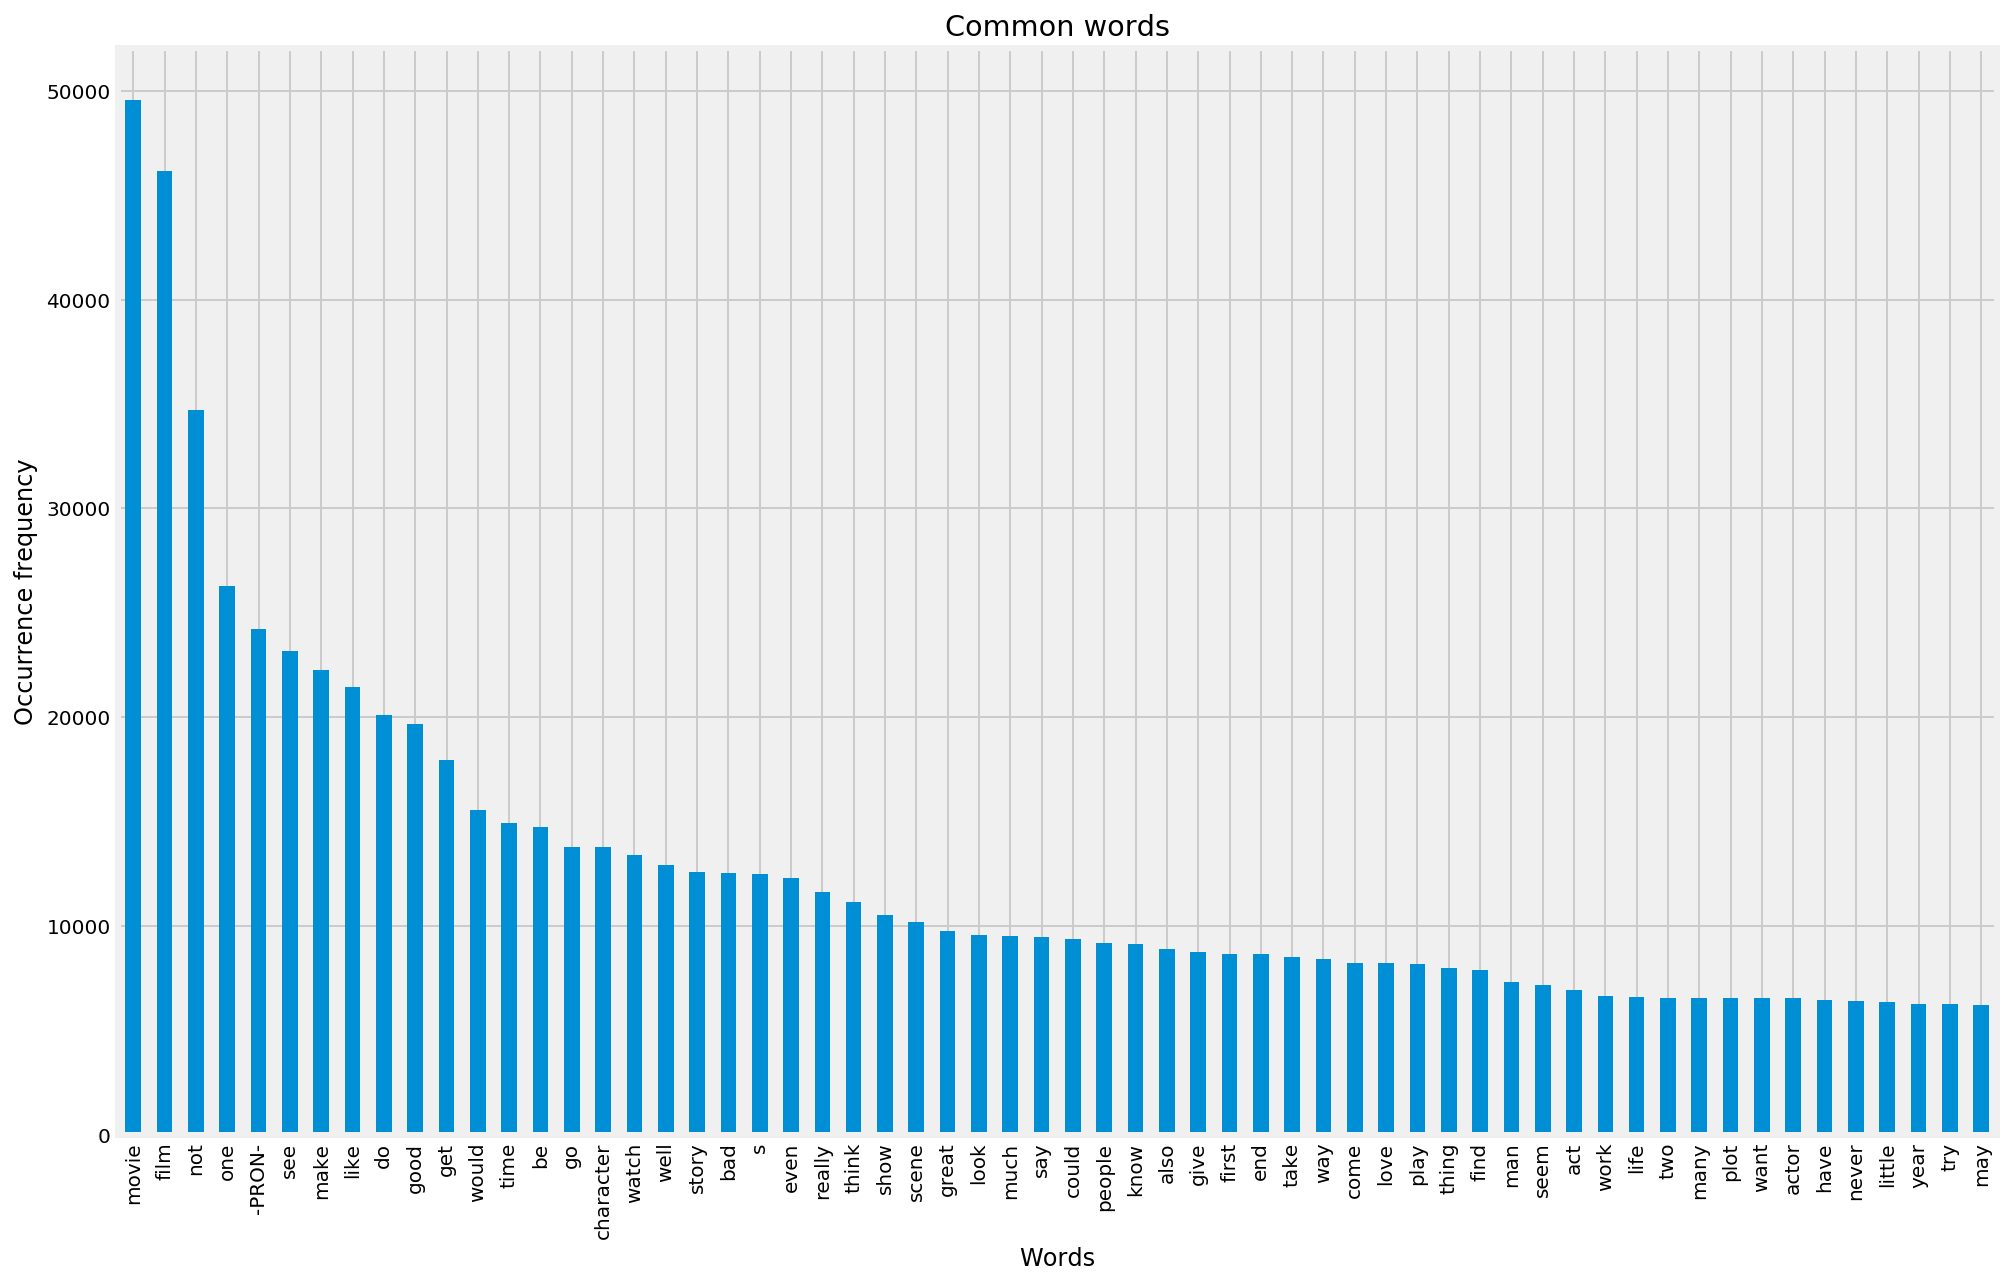

In [173]:
plt.figure(figsize=(15,10))
freq_common[:60].plot.bar()
plt.xlabel('Words')
plt.ylabel('Occurrence frequency')
plt.title('Common words')

### 3.7.2 Remove common words
Remove the first 10 words.

In [171]:
freq_common_10 = list(freq_common[:10].index)
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_common_10))
data['SentimentTextNew'].head()

0    first think another disney may kid watch can h...
1    put aside dr house repeat miss desperate house...
2    big fan stephen king work even great fan king ...
3    watch horrid thing tv needless say watch much ...
4    truly enjoy act terrific plot jeff comb talent...
Name: SentimentTextNew, dtype: object

Check the results.

Text(0.5, 1.0, 'Common words after removing')

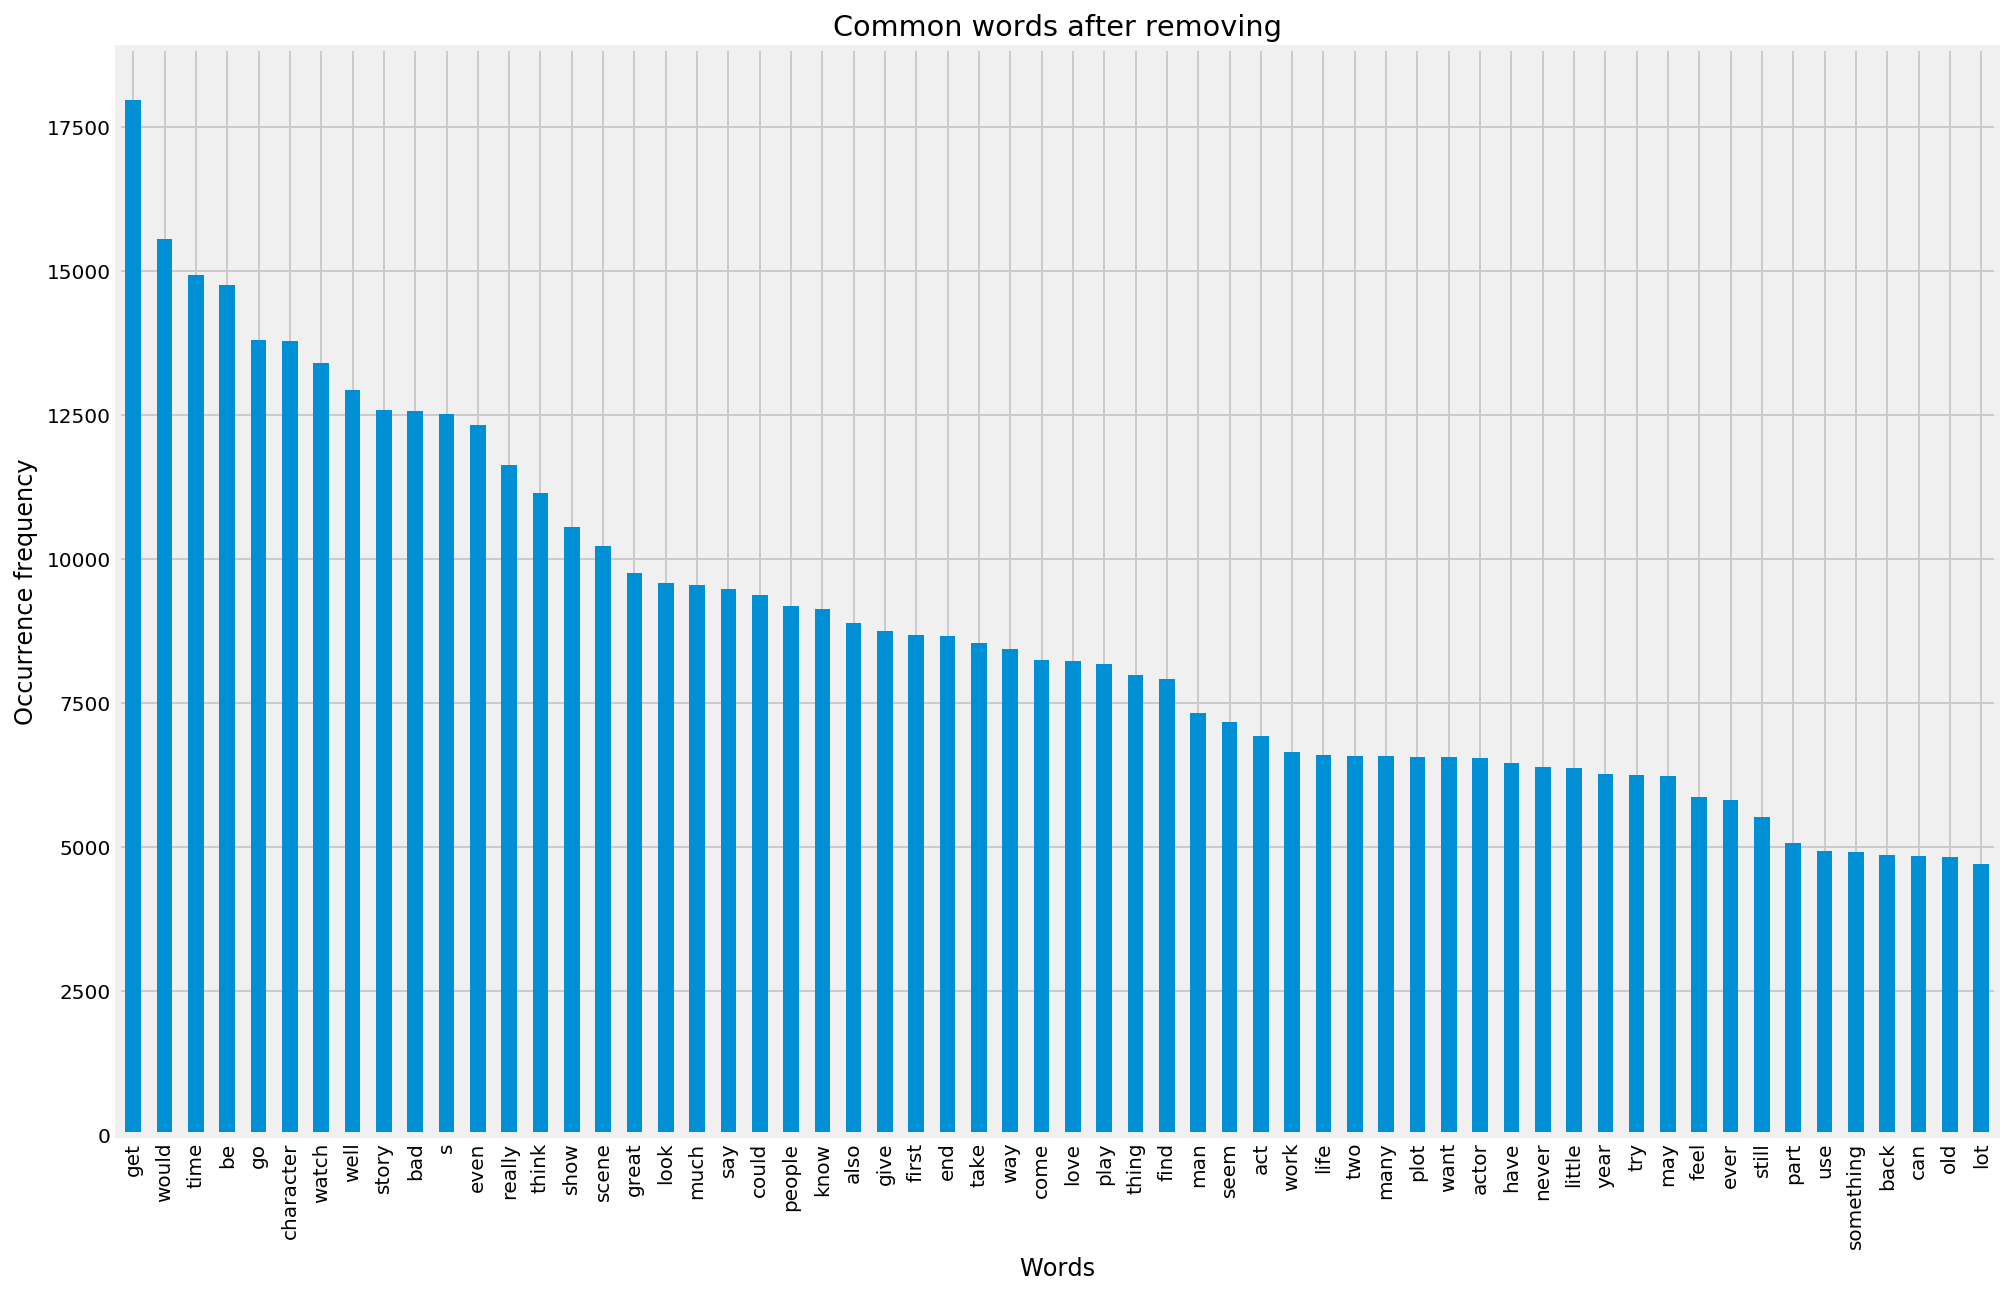

In [174]:
freq_common_new = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
plt.figure(figsize=(15,10))
freq_common_new[:60].plot.bar()
plt.xlabel('Words')
plt.ylabel('Occurrence frequency')
plt.title('Common words after removing')

## 3.8 Rare words

### 3.8.1 Count rare words occurrence frequency

In [175]:
freq_rare = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
freq_rare

get                    17972
would                  15556
time                   14926
be                     14756
go                     13807
                       ...  
alantis                    1
comparativelyplease        1
heft                       1
pointbringe                1
gigs                       1
Length: 127429, dtype: int64

Get the words with only one occurence.

In [135]:
one_occurence = freq_rare[freq_rare==1]
one_occurence

bridging               1
complicitor            1
albertroberto          1
moviecute              1
pinkystyle             1
                      ..
alantis                1
comparativelyplease    1
heft                   1
pointbringe            1
gigs                   1
Length: 80650, dtype: int64

In [136]:
len(one_occurence)

80650

### 3.8.2 Remove rare words

In [0]:
freq_rare = list(one_occurence.index)
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_rare))
data['SentimentTextNew'].head()

## 3.9 Word cloud

### 3.9.1 Word cloud of negative terms

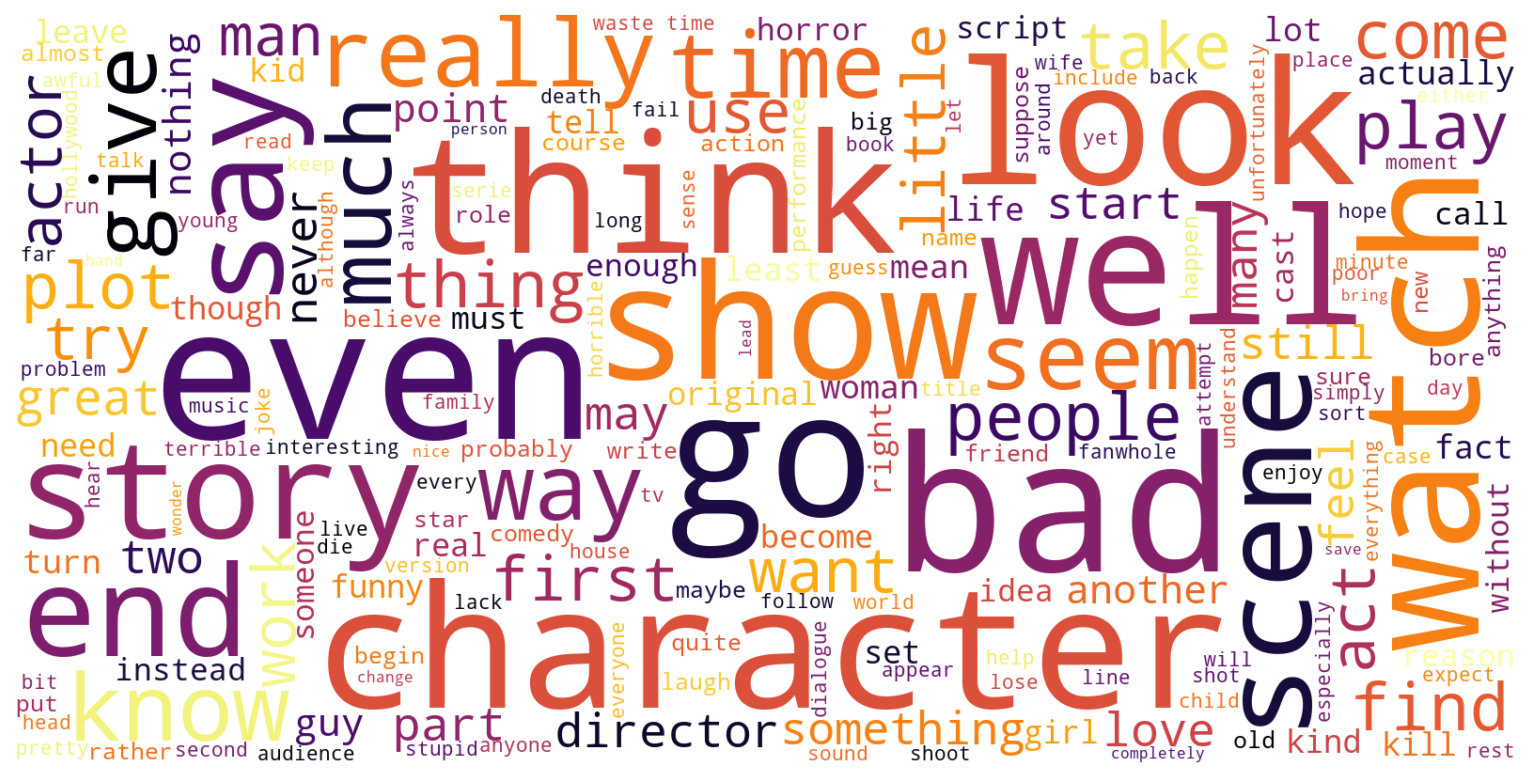

In [118]:
neg_tweets = data[data.Sentiment == 0]
neg_string = []

for t in neg_tweets.SentimentTextNew:
    neg_string.append(t)

neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='inferno',
    background_color='white').generate(neg_string)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.9.2 Word cloud of positive terms

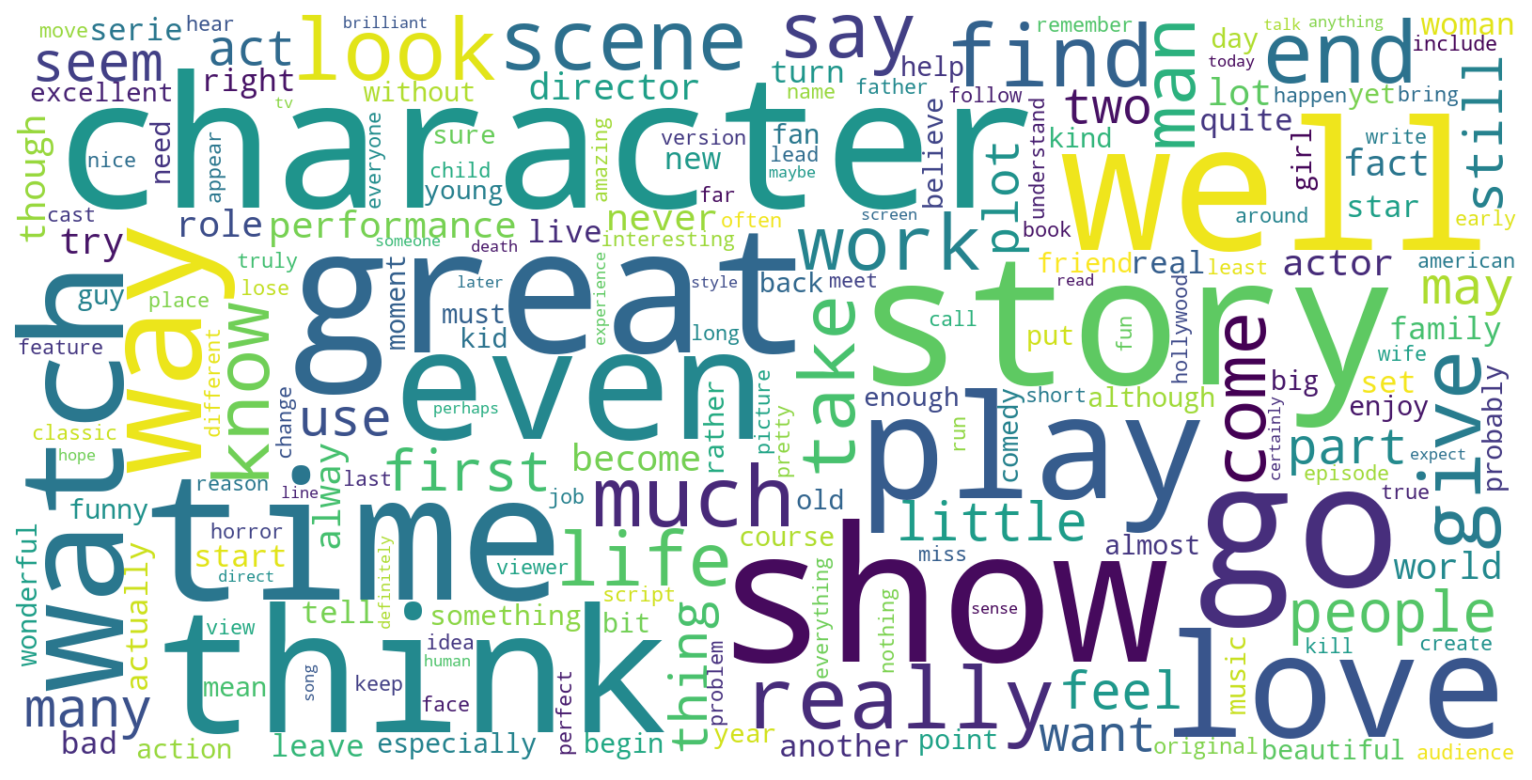

In [120]:
pos_tweets = data[data.Sentiment == 1]
pos_string = []

for t in pos_tweets.SentimentTextNew:
    pos_string.append(t)

pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='viridis',
    background_color='white').generate(pos_string) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

### 3.9.3 Unique words


In [0]:
pos_un = pd.Series(pos_string.split())
neg_un = pd.Series(neg_string.split())

Unique negative words

In [127]:
neg_un = neg_un[~neg_un.isin(pos_un)]
len(neg_un)

61262

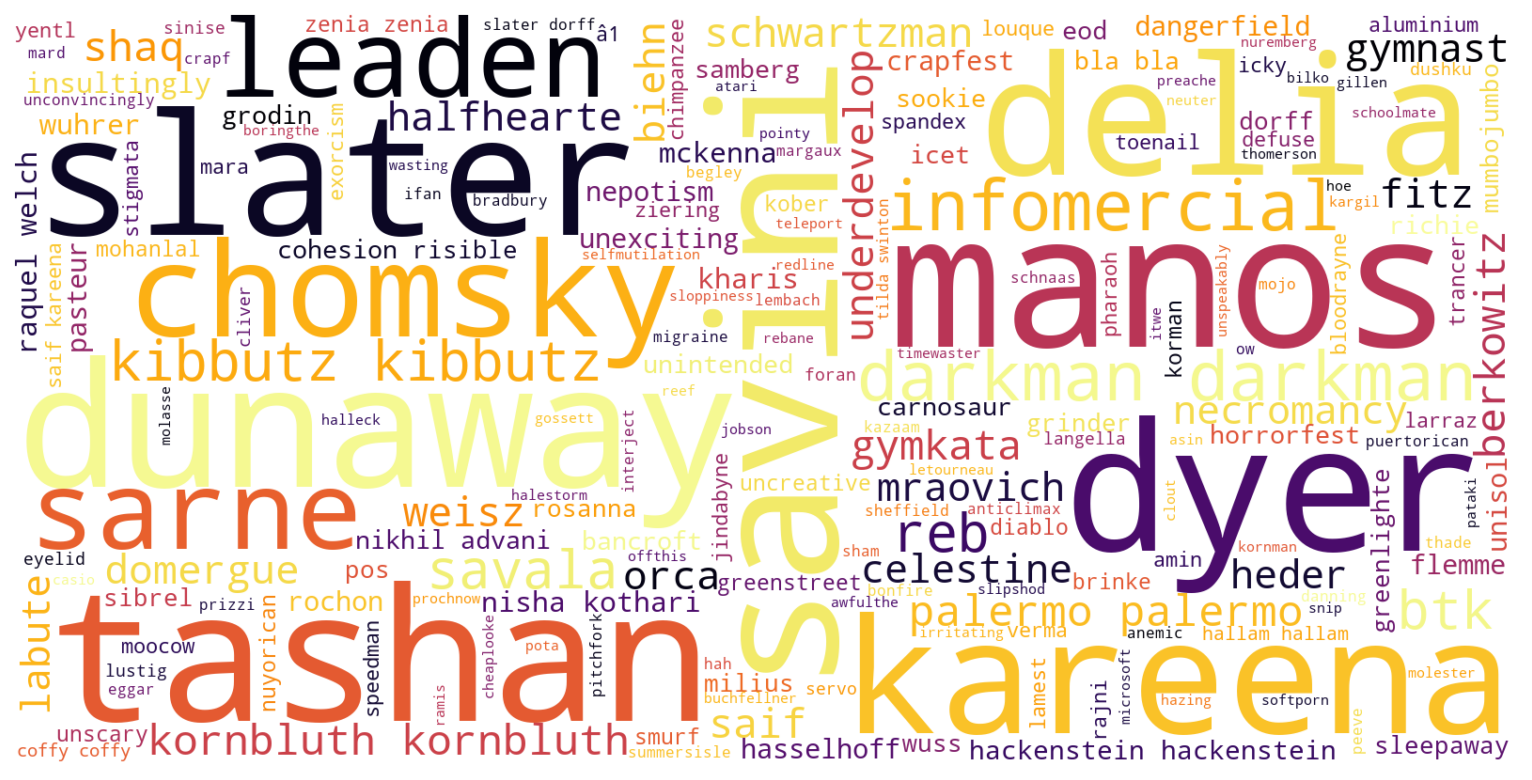

In [125]:
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='inferno',
    background_color='white').generate(neg_un.str.cat(sep=' ')) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

Unique positive words 

In [128]:
pos_un = pos_un[~pos_un.isin(neg_un)]
len(pos_un)

1431182

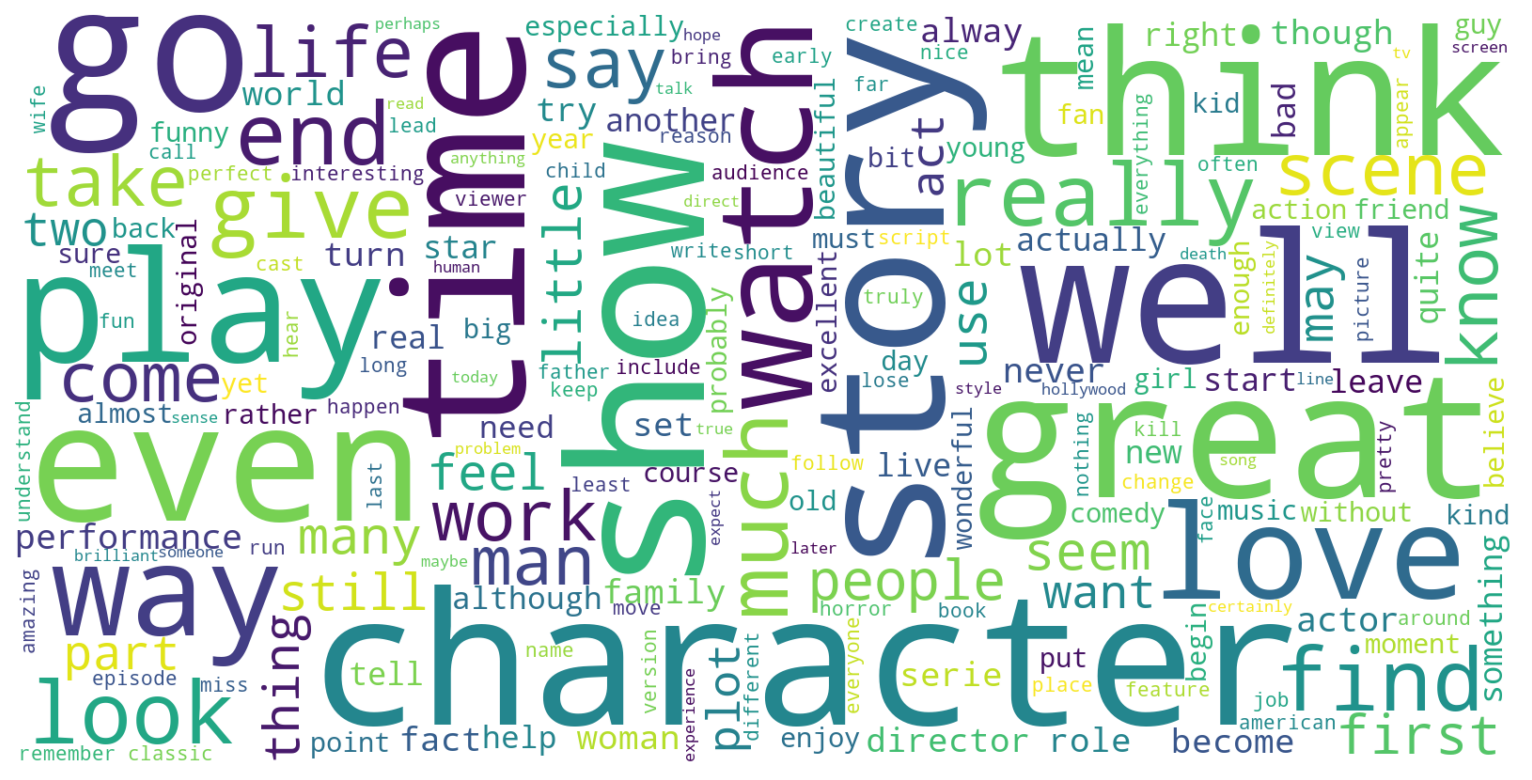

In [126]:
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='viridis',
    background_color='white').generate(pos_un.str.cat(sep=' ')) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

# 4. Feature extraction

## 4.1 Split into train and test

In [0]:
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(data.SentimentText, data.Sentiment, test_size=.2, random_state=SEED)

In [0]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

In [0]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\rafal_000\Anaconda3\envs\RafalEnv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average precision-recall score: 0.84
accuracy score: 89.08%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.85
accuracy score: 89.74%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                        

In [0]:
acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)


data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [0]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 4.1 N-grams
Capture the language structure, like what letter or word is likely to follow the given one

In [0]:
TextBlob(data['SentimentText'][0]).ngrams(2)

TypeError: list indices must be integers or slices, not str

## 4.2 Term frequency - dopracowac
TF = (Number of times term T appears in the particular row) / (number of terms in that row)

In [0]:
#tf1 = (data['SentimentText'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index
#tf1

## 4.3 Inverse Document Frequency - dopracowac
IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

In [0]:
#for i,word in enumerate(tf1['words']):
#  tf1.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['SentimentText'].str.contains(word)])))
#
#tf1